# Building machine learning potentials (MLPs) for liquid water [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Roy-Kid/PiNN/blob/pre-release/docs/notebooks/Build_MLP_Water.ipynb)


This notebook showcases the usage of PiNN with a practical problem of building machine learning potentials for liquid water on the H2O(l)-revPBE0-D3 dataset.
It serves as a basic test and demonstration of the workflow with PiNN.

In [ ]:
# Install PiNN
!pip install tensorflow==2.11
!pip install git+https://github.com/Roy-Kid/PiNN@jichen-pre-release

## Download the H2O(l)-revPBE0-D3 dataset

The H2O(l)-revPBE0-D3 dataset was published by Cheng et al ([Proc. Nat. Acad. Sci. 2019, 116, 1110-1115](https://doi.org/10.1073/pnas.1815117116)). It comprises 1593 liquid water configurations involving 64 molecules with the energies and forces computed by DFT at the revPBE0-D3 level and presents an excellent example to test MLPs in the interpolation regime.

In [3]:
# step 1: download the dataset
import requests
with requests.get("https://raw.githubusercontent.com/BingqingCheng/ab-initio-thermodynamics-of-water/master/training-set/input.data", stream=True) as r:
    r.raise_for_status()
    with open("input.data", 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

# step 2: create project directory
!mkdir MLP_Water

# step 3: move the dataset file to project directory
!mv input.data MLP_Water

## Configure the model architecture and parameters

Three different model architectures are supplied in the PiNN package, i.e., Behler−Parrinello neural network (BPNN, [Phys. Rev. Lett. 2007, 98, 146401](https://doi.org/10.1103/PhysRevLett.98.146401)), PiNet ([J. Chem. Inf. Model. 2020, 60, 1184−1193](https://doi.org/10.1021/acs.jcim.9b00994)), and PiNet2-P3. The BPNN and PiNet only involve invariant features, whereas PiNet2-P3 incorporates equivariant information as well. Generally speaking, the training loss of PiNet2-P3 is lower than that of BPNN/PiNet. Before training the MLPs, it is essential to define the model architecture and set corresponding parameters. In this case, we will use PiNet2-P3 as an example. You can also use following functions to know which networks and models are available.

In [1]:
import pinn
pinn.get_available_networks()

Available networks:
  - PiNet
  - PiNet2
  - BPNN
  - LJ


You can find detailed information about the parameters of both the `model` and the `network` on their respective pages under the `Usage` tab. These sections provide comprehensive guidance on how to configure and implement them effectively for your specific applications. Here is the configuration file for training water model:

In [6]:
import yaml

params = {

    "model":
      {"name": "potential_model",
      "params":
        {"e_loss_multiplier": 10.0,
        "e_scale": 27.2114,
        "e_unit": 27.2114,
        "f_loss_multiplier": 100.0,
        "log_e_per_atom": True,
        "use_e_per_atom": False,
        "use_force": True,}},
    "network":
      {"name": "PiNet2",
      "params":
        {"atom_types": [1, 8],
        "basis_type": "gaussian",
        "depth": 5,
        "ii_nodes": [16, 16, 16, 16],
        "n_basis": 10,
        "out_nodes": [16],
        "pi_nodes": [16],
        "pp_nodes": [16, 16, 16, 16],
        "rank": 3,
        "rc": 6.0,
        "weighted": False}},
    "optimizer":
      {"class_name": "Adam",
      "config":
        {"global_clipnorm": 0.01,
        "learning_rate":
          {"class_name": "ExponentialDecay",
          "config":
            {"decay_rate": 0.994,
            "decay_steps": 100000,
            "initial_learning_rate": 5.0e-05,}}}}

}

with open("MLP_Water/pinet2-pot.yml", 'w') as f:
    yaml.dump(params, f)

## Train the MLP models

In [12]:
import os
import yaml
import warnings
import tensorflow as tf
from pinn import get_model, get_network
from pinn.utils import init_params
from pinn.io import load_runner, write_tfrecord, load_tfrecord, sparse_batch
from tensorflow.python.lib.io.file_io import FileIO
from tempfile import mkdtemp, mkstemp

random_seed = 1 # random seed for data splitting
num_train_steps = 1000 # total number of training steps; typical training step is ~5M steps
eval_per_num_steps = 500 # evaluate the models every eval_per_num_steps steps
batch_size = 1 # batch size
nmax_ckpts = 1 # max number of checkpoint file
nckpt_every = 50 # save the checkpoint file every nckpt_every steps
nlog_every = 50 # write the log file every nlog_every steps
num_shuffle_buffer = 1000
bool_shuffle = True
bool_preprocess = True # turn on/off the preprocess of dataset
bool_cache = True
bool_early_stop = False # turn on/off the early stop

# set the GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# turn off the specific warning of tensorflow
index_warning = 'Converting sparse IndexedSlices'
warnings.filterwarnings('ignore', index_warning)
tf.get_logger().setLevel('ERROR')

project_dir = "MLP_Water/"

# split training and test sets
runner_dataset_file = project_dir + "input.data"
dataset = load_runner(runner_dataset_file, splits={'train':8, 'vali':2}, shuffle=bool_shuffle, seed=random_seed)
write_tfrecord(project_dir + 'train.yml', dataset['train'])
write_tfrecord(project_dir + 'vali.yml', dataset['vali'])

# get model parameters
params = {}
with FileIO(project_dir + "pinet2-pot.yml", 'r') as f:
    params = yaml.load(f, Loader=yaml.Loader)

molde_dir = project_dir + "PiNet2_rPBE0_seed%d"%(random_seed)
params['model_dir'] = molde_dir

# initial some parameters (e.g., e_dress)
ds = load_tfrecord(project_dir + "train.yml")
init_params(params, ds)

scratch_dir = None
if scratch_dir is not None:
    scratch_dir = mkdtemp(prefix='pinn', dir=scratch_dir)
def _dataset_fn(fname):
    dataset = load_tfrecord(fname)
    if batch_size is not None:
        dataset = dataset.apply(sparse_batch(batch_size))
    if bool_preprocess:
        def pre_fn(tensors):
            with tf.name_scope("PRE") as scope:
                network = get_network(params['network'])
                tensors = network.preprocess(tensors)
            return tensors
        dataset = dataset.map(pre_fn)
    if bool_cache:
        if scratch_dir is not None:
            cache_dir = mkstemp(dir=scratch_dir)
        else:
            cache_dir = ''
        dataset = dataset.cache(cache_dir)
    return dataset

train_fn = lambda: _dataset_fn(project_dir + 'train.yml').repeat().shuffle(num_shuffle_buffer)
eval_fn = lambda: _dataset_fn(project_dir + 'vali.yml')
config = tf.estimator.RunConfig(keep_checkpoint_max=nmax_ckpts,
                                log_step_count_steps=nlog_every,
                                save_summary_steps=nlog_every,
                                save_checkpoints_steps=nckpt_every)

model = get_model(params, config=config)

if bool_early_stop:
    early_stop = "loss:1000"
    stops = {s.split(':')[0]: float(s.split(':')[1])
             for s in early_stop.split(',')}
    hooks = [tf.estimator.experimental.stop_if_no_decrease_hook(
        model, k, v) for k,v in stops.items()]
else:
    hooks=None

train_spec = tf.estimator.TrainSpec(input_fn=train_fn, max_steps=num_train_steps, hooks=hooks)
eval_spec  = tf.estimator.EvalSpec(input_fn=eval_fn, steps=eval_per_num_steps)
tf.estimator.train_and_evaluate(model, train_spec, eval_spec)
print('done')

 1275 samples written to MLP_Water/train.tfr, done.
 318 samples written to MLP_Water/vali.tfr, done.
Fitting an atomic dress from the training set.
 RMSE after substracting the dress: 5.477752e-01
45568 trainable vaiables, training with float32 precision.
done


## Check the training loss

In [20]:
import numpy as np

def log(log_dir, tag, fmt):
    from glob import glob
    from sys import stdout
    from warnings import warn
    from itertools import chain
    from tensorboard.backend.event_processing.event_file_loader import LegacyEventFileLoader
    files = sorted(glob(f'{log_dir}/events.out.*'), key=os.path.getmtime)
    logs = {}
    events = chain(*[LegacyEventFileLoader(log).Load() for log in files])
    for event in events:
        for v in event.summary.value:
            if tag not in v.tag:
                continue
            if v.tag not in logs.keys():
                logs[v.tag] = []
            logs[v.tag].append([event.step, v.simple_value])
    logs = {k: np.array(v) for k,v in logs.items()}
    keys = sorted(list(logs.keys()))
    steps = [logs[k][:,0] for k in keys]
    data = [logs[k][:,1] for k in keys]
    steps, rows = np.unique(np.concatenate(steps), return_inverse=True)

    return (steps,data,keys)

log_dir_train = molde_dir + "/"
train_loss = log(log_dir_train,'RMSE', '%14.6e ')

log_dir_eval = molde_dir + "/eval"
eval_loss = log(log_dir_eval,'RMSE', '%14.6e ')
print("done")

done


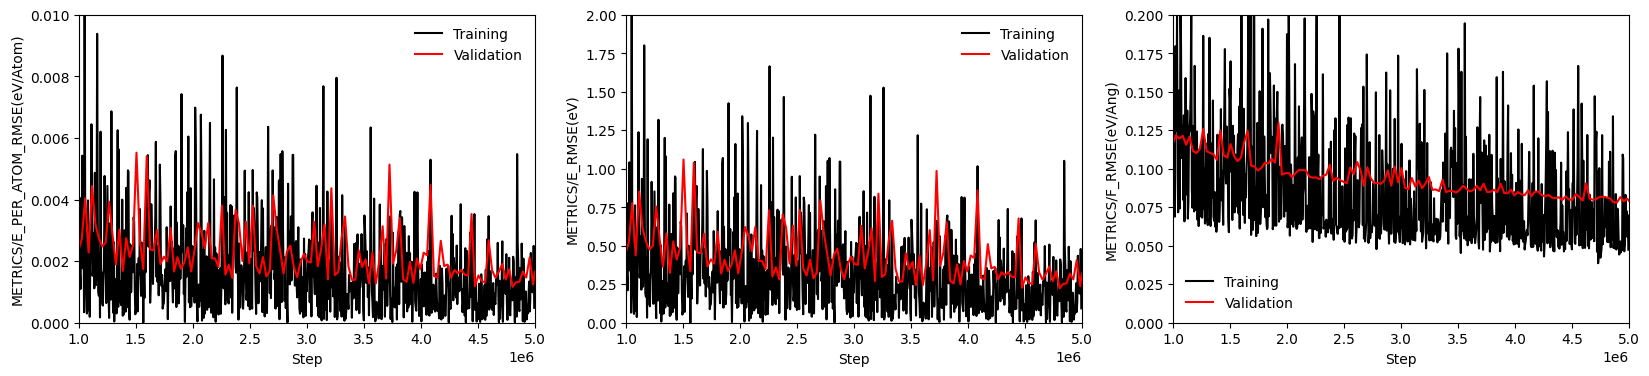

In [32]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

num_metrics = len(train_loss[2])

fig, axs = plt.subplots(1, num_metrics, figsize=(20, 4))

metrics_unit={"METRICS/E_PER_ATOM_RMSE":"eV/Atom",
          "METRICS/E_RMSE":"eV",
          "METRICS/F_RMSE":"eV/Ang"}

metrics_y_max = {"METRICS/E_PER_ATOM_RMSE":0.01,
          "METRICS/E_RMSE":2.0,
          "METRICS/F_RMSE":0.2}

for index in range(0, num_metrics):
    axs[index].set_xlabel(r'Step')
    y_label = "%s(%s)"%(train_loss[2][index], metrics_unit[train_loss[2][index]])
    axs[index].set_ylabel(y_label)
    axs[index].set_xlim(1E6, 5E6)

    axs[index].set_ylim(0.0, metrics_y_max[train_loss[2][index]])

    axs[index].plot(train_loss[0], train_loss[1][index], color='black', label="Training")
    axs[index].plot(eval_loss[0], eval_loss[1][index], color='red', label="Validation")
    axs[index].legend(edgecolor='none', loc='best')

plt.subplots_adjust(hspace=500)

plt.show()

## Run molecular dynamics with ASE

In [ ]:
! pip install ase
! cp ../water.xyz ./MLP_Water/

In [38]:
import pinn
from ase import units
from ase.io import read,write
from ase.io.trajectory import Trajectory
from ase.md import MDLogger
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.nptberendsen import NPTBerendsen
from ase.md.nvtberendsen import NVTBerendsen

setup = {
        'ensemble': 'nvt',  # ensemble
        'T': 330.0,  # temperature
        't': 1000,  # time in fs
        'dt': 0.5,  # timestep in fs
        'taut': 10,  # thermostat damping in steps
        'taup': 1000,  # barastat dampling in steps
        'log-every': 100,  # log interval in steps
        'pressure': 1,  # pressure in bar
        'compressibility': 4.57e-4,  # compressibility in bar^{-1}
    }

ensemble=setup['ensemble']
T = float(setup['T'])
t=float(setup['t'])*units.fs
dt=float(setup['dt'])*units.fs
taut=int(setup['taut'])
taup=int(setup['taup'])
every=int(setup['log-every'])
pressure=float(setup['pressure'])
compressibility=float(setup['compressibility'])

# get calculator
calc = pinn.get_calc(molde_dir + "/params.yml")

# read initial structure
init_structure_file = project_dir + "water.xyz"
atoms = read(init_structure_file)
atoms.set_calculator(calc)

# assign initial velocities (i.e., momenta)
MaxwellBoltzmannDistribution(atoms, T * units.kB)

if ensemble == 'npt':
    dyn = NPTBerendsen(atoms, timestep=dt, temperature=T, pressure=pressure,
                  taut=dt * taut, taup=dt * taup, compressibility=compressibility)
if ensemble == 'nvt':
    dyn = NVTBerendsen(atoms, timestep=dt, temperature=T, taut=dt * taut)

log_file = project_dir + "asemd.log"
dyn.attach(
    MDLogger(dyn, atoms,log_file,stress=True, mode="w"),
    interval=int(50*units.fs/dt))

traj_file = project_dir + "asemd.traj"
dyn.attach(
    Trajectory(traj_file, 'w', atoms).write,
    interval=int(50*units.fs/dt))

# run simulations
dyn.run(int(t/dt))

print("done")

/usr/local/lib/python3.10/dist-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


done


## Analyze the trajectory

Once the trajectory has been acquired, you can perform various analyses based on it, such as calculating the radial distribution function (RDF) for specific pairs of atoms.

In [40]:
import itertools
from ase.io import iread

r_min = 0.0
r_max = 6.0
bin_num = 201
hist = 0

bins = np.linspace(r_min,r_max,bin_num)
r_mid = (bins[1:] + bins[:-1])/2
bin_vol = (bins[1:]**3 - bins[:-1]**3)*4*np.pi/3

from ase.io.trajectory import Trajectory
trajObj = Trajectory(traj_file)
start_fram_index = int(len(trajObj) / 2)

count = 0
traj = iread(traj_file, index=slice(start_fram_index, None))
for data in traj:

    count += 1

    listIndex1 = [idx for idx in range(len(data)) if data[idx].symbol == "O"]
    index_ij = np.array(list(itertools.combinations(listIndex1, 2)))

    data.wrap()

    diff = data.positions[index_ij[:, 0]] - data.positions[index_ij[:, 1]]
    listCellLen = [data.cell[0][0], data.cell[1][1], data.cell[2][2]]
    diff = diff - np.rint(diff / listCellLen) * listCellLen
    dist = np.linalg.norm(diff, axis=1)

    h, edges = np.histogram(dist, bins)

    # normalize by the number density
    rho = dist.shape[0] / data.get_volume()
    hist += h / bin_vol / rho

rdf = hist/count
print("done")

done


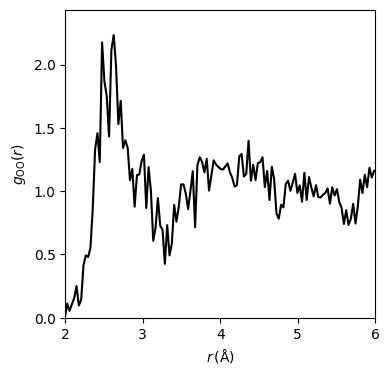

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

axs.set_xlabel(r'$r \, (\mathrm{\AA}$)')
axs.set_ylabel(r'$g_\mathrm{OO}(r)$')
axs.set_xlim(2, 6)

max_value = np.max(rdf)
min_value = np.min(rdf)
axs.set_ylim(min_value, max_value+0.2)

axs.plot(r_mid, rdf, color='black')

plt.subplots_adjust(hspace=500)

plt.show()

## Run jobs in batches

When there is a need for batch model training and MD running jobs, incorporating the aforementioned process into a Nextflow script is a good choice.

* Within the Nextflow framework, a pipeline script is composed of several processes that operate independently of each other.
* Each process is capable of defining multiple input and output channels and can be implemented using any scripting language, such as Bash or Python.
* The communication between two processes can be facilitated via their shared channels.
* A channel is capable of sending/receiving a message that may include values, pathes, files and so on.

You can find more information of Nextflow from https://www.nextflow.io/docs/latest/index.html

Here, we illustrate the Nextflow pipeline script of constructing a series of MLPs with varying hyperparameters across different training datasets.

### Batch MLP training

#### Pipeline script
To instruct Nextflow on executing a batch job, it is necessary to create a pipeline script that outlines the workflow, processes and channels. Thus, we need to create a script file (for example, "**train.nf**") and include the following content within it.
```
#!/usr/bin/env nextflow
nextflow.enable.dsl=2

// step 1: create a collection of yml files including all hyperparameters of PiNN and store them in a directory named "pinn-adam".
// The format of yml files can be found in the section of "Configure the model architecture and parameters".
// After obtaining these files, we can define a parameter in the context of Nextflow for the convenience of creating channel.
params.inputs = './pinn-adam/*.yml'

// step 2: define other parameters.
params.dataset = './input.data' // path of the dataset
params.seeds = 1       // number of seeds to split the dataset
params.steps = 5000000     // max number of steps
params.batch = 1           // batch size
params.ckpts = 1           // number of ckpts to keep, 0 -> all
params.log_every = 50   // log/summary frequency
params.ckpt_every = 50 // checkpoint frequency

// step 3: create a channel that integrates various yml files, datasets, the number of training iterations, and different random split seeds.
model_config = Channel.fromPath(params.inputs)
    .combine(Channel.fromPath(params.dataset))
    .combine(Channel.value(params.steps))
    .combine(Channel.of(1..params.seeds))

//step 4: define entry points for the entire workflow
workflow {
    pinn_train(model_config)
}

def shorten(x) {sprintf('%.5E', (double) x).replaceAll(/\.?0*E/, 'E').replaceAll(/E\+0*/, 'E')}

//step 5: define the training process
process pinn_train {

    publishDir 'models/', mode: 'link'
    tag "PiNet2-$ds.baseName-$input.baseName-B${params.batch}-${shorten(step)}-$seed"
    label 'pinn'

    input:
    tuple (file(input), file(ds), val(step), val(seed))

    output:
    path "PiNet2-$ds.baseName-$input.baseName-B${params.batch}-${shorten(step)}-$seed", type:'dir'

    """
    # PiNN offers a command line interface for loading datasets and training MLPs
    # Certainly, you can use the python source code in the section "Train the MLP models" as an alternative.
    pinn convert $ds -o 'train:8,eval:2' --seed $seed
    pinn train $input -d "PiNet2-$ds.baseName-$input.baseName-B${params.batch}-${shorten(step)}-$seed"\
        --train-steps $params.steps --log-every $params.log_every --ckpt-every $params.ckpt_every\
        --batch $params.batch --max-ckpts $params.ckpts --shuffle-buffer 1000 --init
    """
}
```

#### Configration file
When training MLPs on various machines, you can create a **nextflow.config** file to configure the execution settings on all machines. Here is an example for the alvis machine.

```
profiles {

  alvis {
    params{
      image = 'None'
    }
    executor{
      name = 'slurm'
      queueSize = 100
      submitRateLimit = '120 min'
    }
    process {
      time = '2d'
      accelerator = 1
      executor = 'slurm'

      withLabel: 'pinn' {
        queue = 'alvis'
        clusterOptions = '-N 1 -n 1 --gpus-per-node=V100:1 -J revPBE0'
      }
    }
    singularity {
      enabled = false
    }
  }
}
```

#### Run script
```
! nextflow run train.nf -profile alvis -bg > log.out
```

#### Collect all MLPs into a new directory
```
! mkdir Models
! mv ./work/*/*/PiNet2* ./Models/
```

### Batch MD simulation
Once we have acquired a set of MLPs, we can execute a batch of MD simulations by Nextflow. Here, we will use NVT simulations as an example.

#### Pipeline script
First, we should create a script file **nvt.nf** and include the following content within it.

```
#!/usr/bin/env nextflow
nextflow.enable.dsl=2

// step 1: specify the path of all MLPs.
params.model = './Models/PiNet2*/'

// step 2: define other parameters.
params.md_init = "./water.xyz" //initial strucutre of MD
params.md_ps = 200         // length of NVT simulation

// step 3: create a channel that integrates initial strucutre, various MLPs, and different temperatures.
model_config = Channel.fromPath(params.md_init)
               .combine(Channel.fromPath(params.model, type: 'dir'))
               .combine(Channel.of(250,260,270,300,320))

//step 4: define entry points for the entire workflow
workflow {
    pinn_nvt(model_config)
}

//step 5: define the nvt simulation process
process pinn_nvt {
    publishDir "mds/$pinn_model.baseName", mode: 'link'
    tag "$pinn_model.baseName"
    label 'pinn'

    input:
    tuple (file(md_geo),file(pinn_model),val(temp))

    output:
    file "NVT-${temp}K-${params.md_ps}ps-${md_geo.simpleName}.log"
    file "NVT-${temp}K-${params.md_ps}ps-${md_geo.simpleName}.traj"

    """
    #!/usr/bin/env python3
    import pinn
    import tensorflow as tf
    from ase import units
    from ase.io import read
    from ase.io.trajectory import Trajectory
    from ase.md import MDLogger
    from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
    from ase.md.nvtberendsen import NVTBerendsen

    dTemp = $temp
    calc = pinn.get_calc("$pinn_model")
    atoms = read("$md_geo")
    atoms.set_calculator(calc)
    MaxwellBoltzmannDistribution(atoms, dTemp*units.kB)
    dt = 0.5 * units.fs
    dyn = NVTBerendsen(atoms, timestep=dt, temperature=dTemp, taut=dt*100)

    dyn.attach(
        MDLogger(dyn, atoms, 'NVT-${temp}K-${params.md_ps}ps-${md_geo.simpleName}.log',stress=True, mode="w"),
        interval=int(100*units.fs/dt))
    dyn.attach(
        Trajectory('NVT-${temp}K-${params.md_ps}ps-${md_geo.simpleName}.traj', 'w', atoms).write,
        interval=int(100*units.fs/dt))
    for i in range($params.md_ps):
        dyn.run(int(1e3*units.fs/dt))
 """
}

```

#### Run script
```
! nextflow run nvt.nf -profile alvis -bg > log.out
```